# Table of Contents

1. [Objective](#section1)<br>
2. [Importing Packages](#section2)<br>
3. [Loading Json Data file on to MongoDB](#section3)<br>
4. [Creating Schema for all the Datasets](#section4)<br>
5. [Creating  Master Database](#section5)
    - 5.1 [Loading Covid Death Data in to Master Database](#section501)
    - 5.2 [Loading Mental State Data in to Master Database](#section501)
    - 5.3 [Loading Nursing Data in to Master Database](#section501)
    - 5.4 [Loading Covid Hospital Data in to Master Database](#section501)
5. [Creating Database and Required Tables](#section5)
6. [Apply Joining and Lookup on Postgresql Database](#section6)



## 1. Objective<a id=section1></a>

In depth analysis on Covid-19 Death, Nursing Home, Mental Health and Covid Hospital datasets to indentify key insights.
The analysis was carried out with the help of appropriate databases and libraries such as mongoDB , Postgresql, Pandas, NumPy and, Plotly.

<a id=section2></a>
## 2. Importing Packages

In [46]:
# Import libraries
import pymongo as md
from pymongo import MongoClient
from bson import ObjectId
import json
import pprint
import psycopg2
import pandas.io.sql as sqlio
import pandas as pd
import plotly as pl 
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

<a id=section3></a>
## 3. Calling al the  Required Jupyter Notebook

In [2]:
#%run ./x19220618_DAP_NursingData_01.ipynb

<a id=section4></a>
## 4. Creating Schema for all the datasets

In [3]:
createCovidTable = """
CREATE TABLE coviddata(
DataAsOf date,
StartDate date,
EndDate date,
Groups varchar,
Year integer,
Month integer,
HHSRegion integer,
State varchar,
PlaceOfDeath varchar,
AgeGroup varchar,
COVID19Deaths numeric,
TotalDeaths numeric,
PneumoniaDeaths numeric,
PneumoniaAndCOVID19Deaths numeric,
InfluenzaDeaths numeric,
PneumoniaInfluenzaOrCOVID19Deaths numeric
);
"""

createMentalTable = """
CREATE TABLE mentalstatedata(
Indicator VARCHAR,
Groups VARCHAR,
State VARCHAR,
Subgroup VARCHAR,
Phase VARCHAR,
TimePeriod numeric(5,2),
TimePeriodLabel VARCHAR,
TimePeriodStartDate date,
TimePeriodEndDate date,
Value numeric(5,2),
LowCI numeric(5,2),
HighCI numeric(5,2),
ConfidenceInterval numeric(5,2),
QuartileRange numeric(5,2)
);
"""

createNursingTable = """
CREATE TABLE nursingdata(
WeekEnding date,
ProviderName varchar,
ProviderCity varchar,
ResidentsTotalAdmissionsCOVID19 bigint,
ResidentsTotalConfirmedCOVID19 bigint,
ResidentsTotalSuspectedCOVID19 bigint,
ResidentsWeeklyAllDeaths bigint,
ResidentsTotalAllDeaths bigint,
ResidentsTotalCOVID19Deaths bigint,
NumberofAllBeds bigint,
TotalNumberofOccupiedBeds bigint,
StaffWeeklyConfirmedCOVID19 bigint,
StaffTotalConfirmedCOVID19 bigint,
StaffWeeklySuspectedCOVID19 bigint,
StaffTotalSuspectedCOVID19 bigint,
StaffTotalCOVID19Deaths varchar,
ShortageofNursingStaff varchar,
ShortageofClinicalStaff varchar,
ShortageofAides varchar,
ShortageofOtherStaff varchar,
AnyCurrentSupplyofN95Masks varchar,
OneWeekSupplyofN95Masks varchar,
AnyCurrentSupplyofSurgicalMasks varchar,
OneWeekSupplyofSurgicalMasks varchar,
AnyCurrentSupplyofEyeProtection varchar,
OneWeekSupplyofEyeProtection varchar,
OneWeekSupplyofGowns varchar,
AnyCurrentSupplyofHandSanitizer varchar,
ThreeorMoreConfirmedCOVID19CasesThisWeekorInitialConfirmedCOVID19CasethisWeek varchar,
AbletoTestorObtainResourcestoTestAllCurrentResidentsWithinNext7Days varchar,
AbletoTestorObtainResourcestoTestAllStaffandorPersonnelWithinNext7Days varchar
);
"""


createCovidHospitalTable="""
CREATE TABLE covidhospitaldata (
state    varchar    ,
date    date    ,
critical_staffing_shortage_today_yes    float    ,
critical_staffing_shortage_today_no    float    ,
critical_staffing_shortage_today_not_reported    float    ,
critical_staffing_shortage_anticipated_within_week_yes    float    ,
critical_staffing_shortage_anticipated_within_week_no    float    ,
critical_staffing_shortage_anticipated_within_week_not_reported    float    ,
hospital_onset_covid    float    ,
hospital_onset_covid_coverage    float    ,
inpatient_beds    float    ,
inpatient_beds_coverage    float    ,
inpatient_beds_used    float    ,
inpatient_beds_used_coverage    float    ,
inpatient_beds_used_covid    float    ,
inpatient_beds_used_covid_coverage    float    ,
previous_day_admission_adult_covid_confirmed_coverage    float    ,
previous_day_admission_adult_covid_suspected_coverage    float    ,
previous_day_admission_pediatric_covid_confirmed_coverage    float    ,
previous_day_admission_pediatric_covid_suspected_coverage    float    ,
staffed_adult_icu_bed_occupancy_coverage    float    ,
staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage    float    ,
staffed_icu_adult_patients_confirmed_covid_coverage    float    ,
total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage    float    ,
total_adult_patients_hospitalized_confirmed_covid_coverage    float    ,
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage    float    ,
total_pediatric_patients_hospitalized_confirmed_covid_coverage    float    ,
total_staffed_adult_icu_beds_coverage    float    ,
inpatient_beds_utilization    float    ,
inpatient_beds_utilization_coverage    float    ,
inpatient_beds_utilization_numerator    float    ,
inpatient_beds_utilization_denominator    float    ,
percent_of_inpatients_with_covid    float    ,
percent_of_inpatients_with_covid_coverage    float    ,
percent_of_inpatients_with_covid_numerator    float    ,
percent_of_inpatients_with_covid_denominator    float    ,
inpatient_bed_covid_utilization    float    ,
inpatient_bed_covid_utilization_coverage    float    ,
inpatient_bed_covid_utilization_numerator    float    ,
inpatient_bed_covid_utilization_denominator    float    ,
geocoded_state    varchar    ,
latitude    float    ,
longitude    float    ,
state_desc varchar
);
"""

<a id=section5></a>
## 5 Creating  Master Database in Postgresql

In [4]:
import psycopg2
dbConnection1 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432")
dbConnection1.set_isolation_level(0) # AUTOCOMMIT
dbCursor1 = dbConnection1.cursor()

try:
    dbCursor1.execute('CREATE DATABASE coviddb;')
    dbCursor1.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection1): dbConnection1.close()

Error while connecting to PostgreSQL database "coviddb" already exists



In [5]:
import psycopg2
dbConnection1 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432", database = 'coviddb')
dbConnection1.set_isolation_level(0) # AUTOCOMMIT
dbCursor1 = dbConnection1.cursor()

try:
    #dbCursor1.execute('CREATE DATABASE coviddb;')
    dbCursor1.execute(createCovidTable)
    dbCursor1.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection1): dbConnection1.close()

Error while connecting to PostgreSQL relation "coviddata" already exists



<a id=section501></a>
### 5.1 Loading Covid Death Data in to Master Database


In [6]:
try:
    dbConnection1 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432", database = "coviddb")
    print("Connected!")
    dbConnection1.set_isolation_level(0) # AUTOCOMMIT
    sql = "COPY %s FROM STDIN WITH CSV HEADER DELIMITER AS ','"
    file = open("covid.csv", "r")
    with dbConnection1.cursor() as cur:
        cur.execute("truncate " + "coviddata" + ";")
        cur.copy_expert(sql=sql % "coviddata", file=file)
        dbConnection1.commit()       
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection1): dbConnection1.close()

Connected!


In [7]:
sql1 = """SELECT * FROM coviddata;"""
dbConnection1 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
covid_dataframe = sqlio.read_sql_query(sql1, dbConnection1)
covidTableStrData = pd.DataFrame().from_dict(covid_dataframe)
covidTableStrData

,dataasof,startdate,enddate,groups,year,month,hhsregion,state,placeofdeath,agegroup,covid19deaths,totaldeaths,pneumoniadeaths,pneumoniaandcovid19deaths,influenzadeaths,pneumoniainfluenzaorcovid19deaths
0,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,All Ages,526027.0,4035809.0,453484.0,255848.0,9004.0,731429.0
1,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,0-17 years,238.0,38250.0,646.0,44.0,179.0,1019.0
2,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,18-29 years,1916.0,72834.0,2109.0,850.0,150.0,3313.0
3,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,30-39 years,5583.0,103647.0,5088.0,2561.0,318.0,8406.0
4,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,40-49 years,15134.0,156430.0,12934.0,7445.0,494.0,21048.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33846,2021-03-24,2020-01-01,2020-01-31,By Month,2020,1,1,Vermont,Place of death unknown,50-64 years,0.0,0.0,0.0,0.0,0.0,0.0
33847,2021-03-24,2020-01-01,2020-01-31,By Month,2020,1,1,Vermont,Place of death unknown,65-74 years,0.0,0.0,0.0,0.0,0.0,0.0
33848,2021-03-24,2020-01-01,2020-01-31,By Month,2020,1,1,Vermont,Place of death unknown,75-84 years,0.0,0.0,0.0,0.0,0.0,0.0
33849,2021-03-24,2020-08-01,2020-08-31,By Month,2020,8,5,Wisconsin,Other,0-17 years,0.0,84.0,0.0,0.0,0.0,0.0


In [8]:
for column in covidTableStrData:
     print(column)

dataasof
startdate
enddate
groups
year
month
hhsregion
state
placeofdeath
agegroup
covid19deaths
totaldeaths
pneumoniadeaths
pneumoniaandcovid19deaths
influenzadeaths
pneumoniainfluenzaorcovid19deaths


<a id=section502></a>
## 5.2 Loading  Mental State Data in to Master Database


In [9]:
dbConnection2 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
dbConnection2.set_isolation_level(0) # AUTOCOMMIT
dbCursor2 = dbConnection2.cursor()

try:
    dbCursor2.execute(createMentalTable)
    print("Table Created")
    dbCursor2.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection2): dbConnection2.close()

Error while connecting to PostgreSQL relation "mentalstatedata" already exists



In [10]:
try:
    dbConnection2 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432", database = "coviddb")
    print("Connected!")
    dbConnection2.set_isolation_level(0) # AUTOCOMMIT
    sql = "COPY %s FROM STDIN WITH CSV HEADER DELIMITER AS ','"
    file = open("mentalState.csv", "r")
    with dbConnection2.cursor() as cur:
        cur.execute("truncate " + "mentalstatedata" + ";")
        cur.copy_expert(sql=sql % "mentalstatedata", file=file)
        dbConnection2.commit()       
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection2): dbConnection2.close()

Connected!


In [11]:
sql2 = """SELECT * FROM mentalstatedata;"""
dbConnection2 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
mentalstate_dataframe = sqlio.read_sql_query(sql2, dbConnection2)
mentalStateTableStrData = pd.DataFrame().from_dict(mentalstate_dataframe)
mentalStateTableStrData

,indicator,groups,state,subgroup,phase,timeperiod,timeperiodlabel,timeperiodstartdate,timeperiodenddate,value,lowci,highci,confidenceinterval,quartilerange
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,23.5,22.7,24.3,23.50,27.85
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,32.7,30.2,35.2,32.70,27.85
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,25.7,24.1,27.3,25.70,27.85
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,24.8,23.3,26.2,24.75,27.85
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,23.2,21.5,25.0,23.25,27.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Virginia,Virginia,3 (Jan 6 Ã¯Â¿Â½ Mar 15),26.0,Mar 3 - Mar 15,2021-03-03,2021-03-15,34.3,30.5,38.2,34.35,34.70
5570,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Washington,Washington,3 (Jan 6 Ã¯Â¿Â½ Mar 15),26.0,Mar 3 - Mar 15,2021-03-03,2021-03-15,37.3,34.1,40.6,37.35,37.40
5571,Symptoms of Anxiety Disorder or Depressive Dis...,By State,West Virginia,West Virginia,3 (Jan 6 Ã¯Â¿Â½ Mar 15),26.0,Mar 3 - Mar 15,2021-03-03,2021-03-15,43.5,36.6,50.6,43.60,43.00
5572,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Wisconsin,Wisconsin,3 (Jan 6 Ã¯Â¿Â½ Mar 15),26.0,Mar 3 - Mar 15,2021-03-03,2021-03-15,31.7,27.0,36.6,31.80,29.60


In [12]:
for column in mentalStateTableStrData:
     print(column)

indicator
groups
state
subgroup
phase
timeperiod
timeperiodlabel
timeperiodstartdate
timeperiodenddate
value
lowci
highci
confidenceinterval
quartilerange


<a id=section503></a>
### 5.3 Loading Nursing Data on to Master Database

In [13]:
dbConnection3 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
dbConnection3.set_isolation_level(0) # AUTOCOMMIT
dbCursor3 = dbConnection3.cursor()

try:
    #dbCursor3.execute('CREATE DATABASE nursingdatadb;')
    dbCursor3.execute(createNursingTable)
    print("Table Created")
    dbCursor3.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection3): dbConnection3.close()

Error while connecting to PostgreSQL relation "nursingdata" already exists



In [14]:
try:
    dbConnection3 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432", database = "coviddb")
    print("Connected!")
    dbConnection3.set_isolation_level(0) # AUTOCOMMIT
    sql = "COPY %s FROM STDIN WITH CSV HEADER DELIMITER AS ','"
    file = open("FinalNData.csv", "r")
    with dbConnection3.cursor() as cur:
        cur.execute("truncate " + "nursingdata" + ";")
        cur.copy_expert(sql=sql % "nursingdata", file=file)
        dbConnection3.commit()       
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection3): dbConnection3.close()

Connected!


In [15]:
sql3 = """SELECT * FROM nursingdata;"""
dbConnection3 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
nursing_dataframe = sqlio.read_sql_query(sql3, dbConnection3)
nursingTableStrData = pd.DataFrame().from_dict(nursing_dataframe)
nursingTableStrData

,weekending,providername,providercity,residentstotaladmissionscovid19,residentstotalconfirmedcovid19,residentstotalsuspectedcovid19,residentsweeklyalldeaths,residentstotalalldeaths,residentstotalcovid19deaths,numberofallbeds,...,oneweeksupplyofn95masks,anycurrentsupplyofsurgicalmasks,oneweeksupplyofsurgicalmasks,anycurrentsupplyofeyeprotection,oneweeksupplyofeyeprotection,oneweeksupplyofgowns,anycurrentsupplyofhandsanitizer,threeormoreconfirmedcovid19casesthisweekorinitialconfirmedcovid,abletotestorobtainresourcestotestallcurrentresidentswithinnext7,abletotestorobtainresourcestotestallstaffandorpersonnelwithinne
0,2020-05-24,NORTHBRIDGE HEALTH CARE CENTER,BRIDGEPORT,25,0,0,0,0,0,0,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
1,2020-05-24,"ORCHARD GROVE SPECIALTY CARE CENTER, LLC",UNCASVILLE,6,28,3,0,19,7,120,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
2,2020-07-19,WATROUS NURSING CENTER,MADISON,0,1,1,0,0,0,45,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
3,2020-06-28,APPLE REHAB SHELTON LAKES,SHELTON,1,0,0,1,2,0,106,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
4,2020-09-13,REGALCARE AT GREENWICH,GREENWICH,11,12,0,0,28,14,75,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,2020-08-23,NOTRE DAME CONVALESCENT HOME I,NORWALK,3,22,38,0,17,13,60,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
9078,2021-01-24,LEDGECREST HEALTH CARE,KENSINGTON,6,26,1,0,15,5,55,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
9079,2021-01-31,JOHN L. LEVITOW HEALTH CARE CENTER,ROCKY HILL,12,34,0,0,20,7,125,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
9080,2020-12-06,APPLE REHAB SHELTON LAKES,SHELTON,8,21,0,1,10,0,106,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y


In [16]:
for column in nursingTableStrData:
     print(column)

weekending
providername
providercity
residentstotaladmissionscovid19
residentstotalconfirmedcovid19
residentstotalsuspectedcovid19
residentsweeklyalldeaths
residentstotalalldeaths
residentstotalcovid19deaths
numberofallbeds
totalnumberofoccupiedbeds
staffweeklyconfirmedcovid19
stafftotalconfirmedcovid19
staffweeklysuspectedcovid19
stafftotalsuspectedcovid19
stafftotalcovid19deaths
shortageofnursingstaff
shortageofclinicalstaff
shortageofaides
shortageofotherstaff
anycurrentsupplyofn95masks
oneweeksupplyofn95masks
anycurrentsupplyofsurgicalmasks
oneweeksupplyofsurgicalmasks
anycurrentsupplyofeyeprotection
oneweeksupplyofeyeprotection
oneweeksupplyofgowns
anycurrentsupplyofhandsanitizer
threeormoreconfirmedcovid19casesthisweekorinitialconfirmedcovid
abletotestorobtainresourcestotestallcurrentresidentswithinnext7
abletotestorobtainresourcestotestallstaffandorpersonnelwithinne


<a id=section504></a>
### 5.4 Loading Covid Hospital  Data on to Master Database

In [17]:
dbConnection4 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
dbConnection4.set_isolation_level(0) # AUTOCOMMIT
dbCursor4 = dbConnection4.cursor()

try:
    #dbCursor4.execute('CREATE DATABASE covidhospitaldb;')
    #dbCursor4.execute(createCovidHospitalTable)
    print("Table Created")
    dbCursor4.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection4): dbConnection4.close()

Table Created


In [18]:
try:
    dbConnection4 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432", database = "coviddb")
    print("Connected!")
    dbConnection4.set_isolation_level(0) # AUTOCOMMIT
    sql = "COPY %s FROM STDIN WITH CSV HEADER DELIMITER AS ','"
    file = open("covidHospital1.csv", "r")
    with dbConnection4.cursor() as cur:
        cur.execute("truncate " + "covidhospitaldata" + ";")
        cur.copy_expert(sql=sql % "covidhospitaldata", file=file)
        dbConnection4.commit()       
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection4): dbConnection4.close()

Connected!


In [21]:
sql4 = """SELECT * FROM covidhospitaldata;"""
dbConnection4 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
covidhospital_dataframe = sqlio.read_sql_query(sql4, dbConnection4)
covidHospitalTableStrData = pd.DataFrame().from_dict(covidhospital_dataframe)
covidHospitalTableStrData

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,percent_of_inpatients_with_covid_numerator,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,geocoded_state,latitude,longitude,state_desc
0,IA,2021-01-03,6.0,63.0,57.0,6.0,62.0,58.0,2.0,124.0,...,594.0,4531.0,0.074028,124.0,594.0,8024.0,POINT (-93.500061 42.074659),-93.500061,42.074659,Iowa
1,ID,2021-01-03,4.0,47.0,1.0,7.0,44.0,1.0,5.0,51.0,...,356.0,1941.0,0.097695,51.0,356.0,3644.0,POINT (-114.659366 44.389073),-114.659366,44.389073,Idaho
2,IL,2021-01-03,19.0,171.0,17.0,17.0,173.0,17.0,73.0,202.0,...,4031.0,20611.0,0.125659,202.0,4031.0,32079.0,POINT (-89.148632 40.124144),-89.148632,40.124144,Illinois
3,IN,2021-01-03,22.0,142.0,2.0,29.0,135.0,2.0,9.0,164.0,...,2817.0,11444.0,0.152633,164.0,2817.0,18456.0,POINT (-86.2818 39.919991),-86.281800,39.919991,Indiana
4,KS,2021-01-03,10.0,136.0,4.0,13.0,133.0,4.0,14.0,147.0,...,1042.0,4940.0,0.119249,147.0,1042.0,8738.0,POINT (-98.38018 38.484729),-98.380180,38.484729,Kansas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17503,NJ,2020-09-21,11.0,81.0,1.0,11.0,81.0,1.0,41.0,92.0,...,627.0,15286.0,0.028026,91.0,627.0,22372.0,POINT (-74.655514 40.110253),-74.655514,40.110253,New Jersey
17504,NM,2020-09-21,13.0,36.0,2.0,13.0,36.0,2.0,1.0,49.0,...,122.0,2210.0,0.034620,50.0,122.0,3524.0,POINT (-106.108388 34.421369),-106.108388,34.421369,New Mexico
17505,NV,2020-09-21,4.0,52.0,4.0,5.0,51.0,4.0,40.0,58.0,...,460.0,5618.0,0.055900,58.0,460.0,8229.0,POINT (-114.916992 39.283294),-114.916992,39.283294,Nevada
17506,NY,2020-09-21,9.0,121.0,46.0,8.0,122.0,46.0,29.0,155.0,...,1272.0,30984.0,0.028809,156.0,1227.0,42591.0,POINT (-75.59655 42.921241),-75.596550,42.921241,New York


In [22]:
for column in covidHospitalTableStrData:
     print(column)

state
date
critical_staffing_shortage_today_yes
critical_staffing_shortage_today_no
critical_staffing_shortage_today_not_reported
critical_staffing_shortage_anticipated_within_week_yes
critical_staffing_shortage_anticipated_within_week_no
critical_staffing_shortage_anticipated_within_week_not_reported
hospital_onset_covid
hospital_onset_covid_coverage
inpatient_beds
inpatient_beds_coverage
inpatient_beds_used
inpatient_beds_used_coverage
inpatient_beds_used_covid
inpatient_beds_used_covid_coverage
previous_day_admission_adult_covid_confirmed_coverage
previous_day_admission_adult_covid_suspected_coverage
previous_day_admission_pediatric_covid_confirmed_coverage
previous_day_admission_pediatric_covid_suspected_coverage
staffed_adult_icu_bed_occupancy_coverage
staffed_icu_adult_patients_confirmed_and_suspected_covid_covera
staffed_icu_adult_patients_confirmed_covid_coverage
total_adult_patients_hospitalized_confirmed_and_suspected_covid
total_adult_patients_hospitalized_confirmed_covid_co

<a id=section6></a>
## 6. Apply Joining and Lookup on Postgresql Database

In [23]:
display(covidTableStrData.head(), mentalStateTableStrData.head(), nursingTableStrData.head(), covidHospitalTableStrData.head())

,dataasof,startdate,enddate,groups,year,month,hhsregion,state,placeofdeath,agegroup,covid19deaths,totaldeaths,pneumoniadeaths,pneumoniaandcovid19deaths,influenzadeaths,pneumoniainfluenzaorcovid19deaths
0,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,All Ages,526027.0,4035809.0,453484.0,255848.0,9004.0,731429.0
1,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,0-17 years,238.0,38250.0,646.0,44.0,179.0,1019.0
2,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,18-29 years,1916.0,72834.0,2109.0,850.0,150.0,3313.0
3,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,30-39 years,5583.0,103647.0,5088.0,2561.0,318.0,8406.0
4,2021-03-24,2020-01-01,2021-03-20,By Total,2020,1,0,United States,Total - All Places of Death,40-49 years,15134.0,156430.0,12934.0,7445.0,494.0,21048.0


,indicator,groups,state,subgroup,phase,timeperiod,timeperiodlabel,timeperiodstartdate,timeperiodenddate,value,lowci,highci,confidenceinterval,quartilerange
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,23.5,22.7,24.3,23.50,27.85
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,32.7,30.2,35.2,32.70,27.85
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,25.7,24.1,27.3,25.70,27.85
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,24.8,23.3,26.2,24.75,27.85
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1.0,Apr 23 - May 5,2020-04-23,2020-05-05,23.2,21.5,25.0,23.25,27.85


,weekending,providername,providercity,residentstotaladmissionscovid19,residentstotalconfirmedcovid19,residentstotalsuspectedcovid19,residentsweeklyalldeaths,residentstotalalldeaths,residentstotalcovid19deaths,numberofallbeds,...,oneweeksupplyofn95masks,anycurrentsupplyofsurgicalmasks,oneweeksupplyofsurgicalmasks,anycurrentsupplyofeyeprotection,oneweeksupplyofeyeprotection,oneweeksupplyofgowns,anycurrentsupplyofhandsanitizer,threeormoreconfirmedcovid19casesthisweekorinitialconfirmedcovid,abletotestorobtainresourcestotestallcurrentresidentswithinnext7,abletotestorobtainresourcestotestallstaffandorpersonnelwithinne
0,2020-05-24,NORTHBRIDGE HEALTH CARE CENTER,BRIDGEPORT,25,0,0,0,0,0,0,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
1,2020-05-24,"ORCHARD GROVE SPECIALTY CARE CENTER, LLC",UNCASVILLE,6,28,3,0,19,7,120,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
2,2020-07-19,WATROUS NURSING CENTER,MADISON,0,1,1,0,0,0,45,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
3,2020-06-28,APPLE REHAB SHELTON LAKES,SHELTON,1,0,0,1,2,0,106,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y
4,2020-09-13,REGALCARE AT GREENWICH,GREENWICH,11,12,0,0,28,14,75,...,Y,Y,Y,Y,Y,Y,Y,N,Y,Y


,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,percent_of_inpatients_with_covid_numerator,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,geocoded_state,latitude,longitude,state_desc
0,IA,2021-01-03,6.0,63.0,57.0,6.0,62.0,58.0,2.0,124.0,...,594.0,4531.0,0.074028,124.0,594.0,8024.0,POINT (-93.500061 42.074659),-93.500061,42.074659,Iowa
1,ID,2021-01-03,4.0,47.0,1.0,7.0,44.0,1.0,5.0,51.0,...,356.0,1941.0,0.097695,51.0,356.0,3644.0,POINT (-114.659366 44.389073),-114.659366,44.389073,Idaho
2,IL,2021-01-03,19.0,171.0,17.0,17.0,173.0,17.0,73.0,202.0,...,4031.0,20611.0,0.125659,202.0,4031.0,32079.0,POINT (-89.148632 40.124144),-89.148632,40.124144,Illinois
3,IN,2021-01-03,22.0,142.0,2.0,29.0,135.0,2.0,9.0,164.0,...,2817.0,11444.0,0.152633,164.0,2817.0,18456.0,POINT (-86.2818 39.919991),-86.281800,39.919991,Indiana
4,KS,2021-01-03,10.0,136.0,4.0,13.0,133.0,4.0,14.0,147.0,...,1042.0,4940.0,0.119249,147.0,1042.0,8738.0,POINT (-98.38018 38.484729),-98.380180,38.484729,Kansas


In [ ]:
# sql5 = """ select * from
# (
# select cd.enddate, cd.state,  sum(cd.totaldeaths) as TotalDeaths, sum(cd.covid19deaths) as CovidDeaths, sum(cd.pneumoniadeaths) as PneumoniaDeaths, sum(cd.pneumoniaandcovid19deaths) as PneumoniaandCovidDeaths, sum(cd.influenzadeaths) as InfluenzaDeaths , sum(cd.pneumoniainfluenzaorcovid19deaths)as PICDeaths 
# from coviddata cd
# group by  cd.enddate,cd.state)a

# join
# (
# select ms.state, ms.indicator, sum(ms.confidenceinterval) as ConfidenceInterval, sum(ms.quartilerange) as QuartileRange from mentalstatedata ms
# group by ms.state, ms.indicator
# ) b on a.state = b.state 

# join
# (select state_desc, sum(critical_staffing_shortage_today_yes) as StaffShortage, sum(critical_staffing_shortage_today_no)as NoStaffShortage , sum(hospital_onset_covid_coverage) as hospital_onset_covid_coverage, sum(inpatient_beds_used_coverage)as inpatient_beds_used_coverage,  sum(inpatient_beds_used_covid) as inpatient_beds_used_covid
#  from covidhospitaldata 
# group by state_desc)d on d.state_desc = a.state

# left join

# (select weekending, sum(residentstotalalldeaths) as ResidentTotalDeath, sum(residentstotalcovid19deaths)as ResidentTotalCovidDeaths , sum(stafftotalconfirmedcovid19) as TotalConfirmedCovid19, sum(stafftotalsuspectedcovid19)as StaffSuspectedCovid,  sum(numberofallbeds) as Numberofallbeds, sum(totalnumberofoccupiedbeds) as TotalOccupiedBeds
#  from nursingdata 
#  group by weekending)c on a.enddate = c.weekending and a.state = 'Connecticut'; """
# dbConnection5 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
# covidDataFrame = sqlio.read_sql_query(sql5, dbConnection5)
# covidTableStrData = pd.DataFrame().from_dict(covidDataFrame)
# covidTableStrData

In [24]:
sql5 = """ SELECT * FROM 
(SELECT 
 enddate,
 groups,
 state,
 placeofdeath,
 AgeGroup,
 SUM(covid19deaths) covid19deaths,
 SUM(totaldeaths) totaldeaths,
 SUM(pneumoniadeaths) pneumoniadeaths,
 SUM(pneumoniaandcovid19deaths) pneumoniaandcovid19deaths,
 SUM(influenzadeaths) influenzadeaths,
 SUM(pneumoniainfluenzaorcovid19deaths) pneumoniainfluenzaorcovid19deaths
 from public.coviddata
 where AgeGroup='All Ages'
 and placeofdeath='Total - All Places of Death'
 and groups='By Month'
 group by
  enddate,
 groups,
 state,
 placeofdeath,
 AgeGroup) COVID
 
 LEFT OUTER JOIN
 
 (SELECT 
 indicator, 
 groups, 
 subgroup, 
 timeperiodenddate, 
 SUM(value) as value, 
 SUM(lowci) lowci, 
 SUM(highci) highci, 
 SUM(confidenceinterval) confidenceinterval, 
 SUM(quartilerange) quartilerange
 from public.mentalstatedata
 where indicator='Symptoms of Anxiety Disorder or Depressive Disorder'
  and groups='By State'
  group by 
   indicator, 
 groups, 
 subgroup, 
 timeperiodenddate ) MENTAL
 
 ON MENTAL.subgroup=COVID.state AND MENTAL.timeperiodenddate=COVID.enddate

 JOIN

(SELECT
state_desc,
date,
sum(critical_staffing_shortage_today_yes) critical_staffing_shortage_today_yes,
sum(critical_staffing_shortage_today_no) critical_staffing_shortage_today_no,
sum(critical_staffing_shortage_today_not_reported) critical_staffing_shortage_today_not_reported,
sum(hospital_onset_covid) hospital_onset_covid,
sum(hospital_onset_covid_coverage) hospital_onset_covid_coverage,
sum(inpatient_beds) inpatient_beds,
sum(inpatient_beds_coverage) inpatient_beds_coverage,
sum(inpatient_beds_used) inpatient_beds_used,
sum(inpatient_beds_used_coverage) inpatient_beds_used_coverage,
sum(inpatient_beds_used_covid) inpatient_beds_used_covid,
sum(inpatient_beds_used_covid_coverage) inpatient_beds_used_covid_coverage,
sum(staffed_adult_icu_bed_occupancy_coverage) staffed_adult_icu_bed_occupancy_coverage,
sum(staffed_icu_adult_patients_confirmed_and_suspected_covid_covera) staffed_icu_adult_patients_conf_and_sus_covid_coverage,
sum(staffed_icu_adult_patients_confirmed_covid_coverage) staffed_icu_adult_patients_confirmed_covid_coverage,
sum(inpatient_beds_utilization) inpatient_beds_utilization,
sum(percent_of_inpatients_with_covid) percent_of_inpatients_with_covid,
sum(inpatient_bed_covid_utilization) inpatient_bed_covid_utilization
from public.covidhospitaldata
group by 
state_desc,
date) COVID_HOSPITAL

 ON COVID.state=COVID_HOSPITAL.state_desc AND COVID.enddate=COVID_HOSPITAL.date

LEFT OUTER JOIN
 
(SELECT
weekending, 
-- providername,
-- providercity,
sum(residentstotaladmissionscovid19) residentstotaladmissionscovid19,
sum(residentstotalconfirmedcovid19) residentstotalconfirmedcovid19,
sum(residentstotalsuspectedcovid19) residentstotalsuspectedcovid19,
sum(residentsweeklyalldeaths) residentsweeklyalldeaths,
sum(residentstotalalldeaths) residentstotalalldeaths,
sum(residentstotalcovid19deaths) residentstotalcovid19deaths,
sum(numberofallbeds) numberofallbeds,
sum(totalnumberofoccupiedbeds) totalnumberofoccupiedbeds
from public.nursingdata
group by weekending) NURSING

ON COVID.state='Connecticut'
AND COVID.enddate=NURSING.weekending """

In [25]:

dbConnection5 = psycopg2.connect(user = "postgres",password = "aa",host = "localhost",port = "5432",database = "coviddb")
covidDataFrame = sqlio.read_sql_query(sql5, dbConnection5)


In [26]:
covidTableStrData = pd.DataFrame().from_dict(covidDataFrame)
covidTableStrData
covidTableStrData.columns

Index(['enddate', 'groups', 'state', 'placeofdeath', 'agegroup',
       'covid19deaths', 'totaldeaths', 'pneumoniadeaths',
       'pneumoniaandcovid19deaths', 'influenzadeaths',
       'pneumoniainfluenzaorcovid19deaths', 'indicator', 'groups', 'subgroup',
       'timeperiodenddate', 'value', 'lowci', 'highci', 'confidenceinterval',
       'quartilerange', 'state_desc', 'date',
       'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported', 'hospital_onset_covid',
       'hospital_onset_covid_coverage', 'inpatient_beds',
       'inpatient_beds_coverage', 'inpatient_beds_used',
       'inpatient_beds_used_coverage', 'inpatient_beds_used_covid',
       'inpatient_beds_used_covid_coverage',
       'staffed_adult_icu_bed_occupancy_coverage',
       'staffed_icu_adult_patients_conf_and_sus_covid_coverage',
       'staffed_icu_adult_patients_confirmed_covid_coverage',
       'inpatient_beds_utilization', 'pe

<a id=section8></a>
## 8. Visualization

<a id=section801></a>
## 8.1 Total Deaths & Covid Deaths vs State (Pyschological Influence)

In [29]:
import numpy as np 
Deaths_MentalHealth = pd.DataFrame(covidTableStrData[['state','indicator','totaldeaths','covid19deaths']][covidTableStrData['indicator'].notnull()])
DM1 = pd.DataFrame(covidTableStrData[['state','indicator','totaldeaths','covid19deaths']][covidTableStrData['indicator'].notnull()])
Deaths_MentalHealth


# covidTableStrData.to_csv(r'/Users/adityaraj/Desktop/Database and Analytics Programming Folder/CA Project/Result.csv')
Deaths_MentalHealth1 = pd.DataFrame(covidTableStrData[['state','indicator','totaldeaths','covid19deaths']][covidTableStrData['indicator'].isnull()])
DM2 = pd.DataFrame(covidTableStrData[['state','indicator','totaldeaths','covid19deaths']][covidTableStrData['indicator'].isnull()])

In [31]:
DM1 = pd.DataFrame(Deaths_MentalHealth.groupby(['state','indicator'], as_index=False)['totaldeaths','covid19deaths'].sum().sort_values('totaldeaths'))
DM2 = pd.DataFrame(Deaths_MentalHealth1.groupby(['state'], as_index=False)['totaldeaths','covid19deaths'].sum().sort_values('totaldeaths'))

C:\Users\ashwi\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\Users\ashwi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


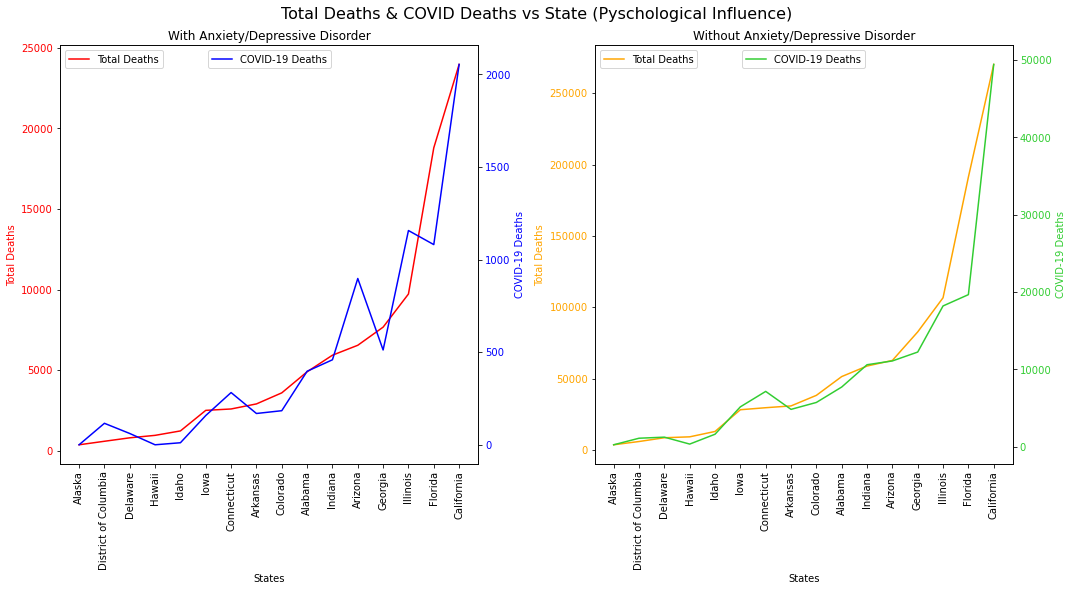

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def two_scales(ax1, time, data1, data2, c1, c2,t):
    ax2 = ax1.twinx()
    ax1.plot(time, data1, color=c1)
#     ax1.set_title('Total Deaths Against COVID Deaths Amongst People with Anxiety or Depressive Disorder')
    ax1.set_xlabel('States')
    ax1.set_ylabel('Total Deaths',color=c1)
    ax1.legend(['Total Deaths'])
#     ax1.legend(ax1.plot(time, data1, color=c1))
#     ax1.legend(loc="upper left")
    
    ax1.set_title(t)
    
    ax2.plot(time, data2, color=c2)
#     ax2.set_title('Total Deaths Against COVID Deaths Amongst People without Anxiety or Depressive Disorder',fontsize=5)
    ax2.set_ylabel('COVID-19 Deaths',color=c2)
    ax2.legend(['COVID-19 Deaths'],loc='upper center')
#     ax2.set_xticklabels(rotation=90)
#     ax2.legend(loc="upper left")
#     ax2.set_title('Without Anxiety/Depressive Disorder')
    return ax1, ax2



# # Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
# s2 = np.sin(2 * np.pi * t)

# Create axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1, ax1a = two_scales(ax1, DM1['state'], DM1['totaldeaths'], DM1['covid19deaths'], 'r', 'b','With Anxiety/Depressive Disorder')
ax2, ax2a = two_scales(ax2, DM2['state'], DM2['totaldeaths'], DM2['covid19deaths'], 'orange', 'limegreen','Without Anxiety/Depressive Disorder')
fig.suptitle('Total Deaths & COVID Deaths vs State (Pyschological Influence)',y =1.02, fontsize=16, )

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
#     for i in ax.get_xticklabels():
#         i.set_xticklabels(rotation=90)
        ax.set_xticklabels(labels=DM1['state'].unique(),rotation=90)


color_y_axis(ax1, 'r')
color_y_axis(ax1a, 'b')
color_y_axis(ax2, 'orange')
color_y_axis(ax2a, 'limegreen')


plt.tight_layout()
plt.show()

In [87]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]],subplot_titles=("With Anxiety/Depressive Disorder", "Without Anxiety/Depressive Disorder")
                   )

# Top left
fig.add_trace(
    go.Scatter(x=DM1['state'], y=DM1['totaldeaths'], name="Total Deaths",marker_color='red'),
    row=1, col=1, secondary_y=False)

fig.add_trace(
    go.Scatter(x=DM1['state'], y=DM1['covid19deaths'], name="Covid-19 Deaths",marker_color='blue'),
    row=1, col=1, secondary_y=True,
)

# Top right
fig.add_trace(
    go.Scatter(x=DM2['state'], y=DM2['totaldeaths'], name="Total Deaths",marker_color='orange'),
    row=1, col=2, secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=DM2['state'], y = DM2['covid19deaths'], name="Covid-19 Deaths", marker_color='limegreen'),
    row=1, col=2, secondary_y=True,
)
fig.update_layout(height=600, width=1100, title_text="Total Deaths & COVID Deaths vs State (Pyschological Influence)")
#fig.update_annotations(dict(font_size=8))


fig.show()

<a id=section802></a>
## 8.2 Inpatient Beds Utilization vs Inpatient Covid-19 Patient Beds

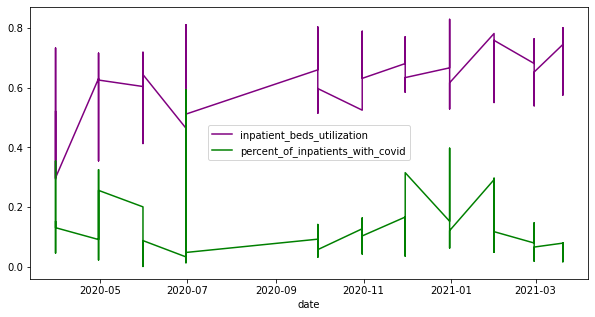

In [103]:
plt.rcParams["figure.figsize"] = (10,5)
# covidTableStrData.plot(x="state", y=["totaldeaths", "covid19deaths"])
#plt.figure(figsize=(100,100))
# covidTableStrData.plot(x="state", y=["critical_staffing_shortage_today_yes","critical_staffing_shortage_today_no"])
import datetime
# [covidTableStrData['date']==datetime.date(2020,6,30)]
covidTableStrData.plot(x="date", y=['inpatient_beds_utilization', 'percent_of_inpatients_with_covid'],color=["purple","green","red"])


# covidTableStrData.to_csv("RESULT.csv")

In [71]:
fig = go.Figure()
fig.add_trace(go.Bar(x=covidTableStrData['date'], y=covidTableStrData['inpatient_beds_utilization'],name='inpatient_beds_utilization',
    marker_color='orange'))
fig.add_trace(go.Bar(x=covidTableStrData['date'], y=covidTableStrData['percent_of_inpatients_with_covid'], name ='percent_of_inpatients_with_covid',marker_color='brown' ))
fig.update_layout(
    title={'text': "Inpatient Bed Utilisation vs Percent of Inpatient beds with Covid-19",'y':0.9,'x':0.45,'xanchor': 'center', 'yanchor': 'top'})
fig.write_html("Inpatient Bed Utilisation vs Percent of Inpatient beds with covid.html") #Interactive graphs will be visible in the mentioned html file
fig.show()

<a id=section803></a>
## 8.3 Distribution of Pneumonia Deaths , Inpatient Beds Used based on Cities

In [ ]:
covidTableStrData.columns

In [ ]:
covidTableStrData.columns

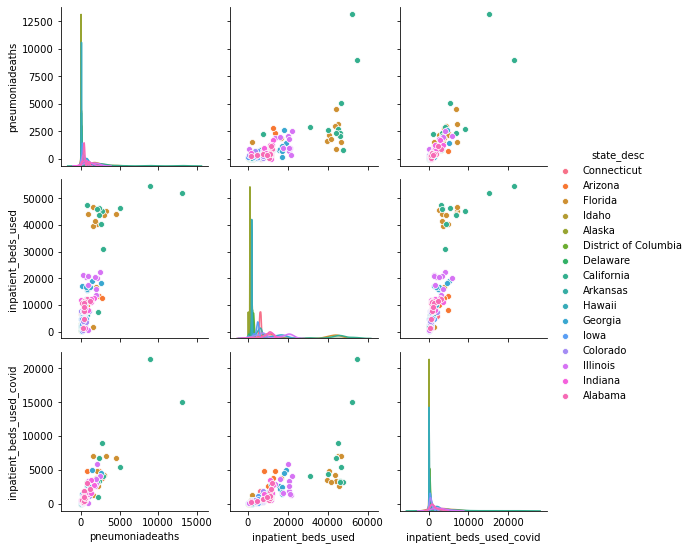

In [104]:
import seaborn as sns
b = pd.DataFrame(covidTableStrData[['state_desc','pneumoniadeaths','inpatient_beds_used', 'inpatient_beds_used_covid']] )
sns.pairplot(b, hue = 'state_desc')


In [105]:
fig = px.scatter_matrix(covidTableStrData,
    dimensions=["pneumoniadeaths", "inpatient_beds_used", "inpatient_beds_used_covid"],
    color="state_desc")
fig.show(width=1000, height=1000 )

In [ ]:
covidTableStrData.info()

<a id=section804></a>
## 8.4 Connecticut Covid-19 Deaths

In [109]:
dm1 = covidTableStrData.sort_values(by=['date'])[covidTableStrData['residentstotaladmissionscovid19'].notnull()]
dm1

C:\Users\ashwi\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,enddate,groups,state,placeofdeath,agegroup,covid19deaths,totaldeaths,pneumoniadeaths,pneumoniaandcovid19deaths,influenzadeaths,...,inpatient_bed_covid_utilization,weekending,residentstotaladmissionscovid19,residentstotalconfirmedcovid19,residentstotalsuspectedcovid19,residentsweeklyalldeaths,residentstotalalldeaths,residentstotalcovid19deaths,numberofallbeds,totalnumberofoccupiedbeds
2,2020-05-31,By Month,Connecticut,Total - All Places of Death,All Ages,1531.0,4015.0,477.0,350.0,0.0,...,0.067901,2020-05-31,1489.0,5939.0,2605.0,266.0,2672.0,1665.0,24540.0,17766.0
0,2021-01-31,By Month,Connecticut,Total - All Places of Death,All Ages,979.0,3588.0,478.0,371.0,0.0,...,0.123191,2021-01-31,5098.0,11241.0,3598.0,149.0,6951.0,2802.0,24533.0,17810.0
1,2021-02-28,By Month,Connecticut,Total - All Places of Death,All Ages,329.0,1427.0,184.0,138.0,0.0,...,0.060395,2021-02-28,5577.0,11438.0,3598.0,104.0,7371.0,2865.0,24533.0,17923.0


In [111]:
dm2 = covidTableStrData.sort_values(by=['date'])[covidTableStrData['residentstotalconfirmedcovid19'].notnull()]
dm2

C:\Users\ashwi\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,enddate,groups,state,placeofdeath,agegroup,covid19deaths,totaldeaths,pneumoniadeaths,pneumoniaandcovid19deaths,influenzadeaths,...,inpatient_bed_covid_utilization,weekending,residentstotaladmissionscovid19,residentstotalconfirmedcovid19,residentstotalsuspectedcovid19,residentsweeklyalldeaths,residentstotalalldeaths,residentstotalcovid19deaths,numberofallbeds,totalnumberofoccupiedbeds
2,2020-05-31,By Month,Connecticut,Total - All Places of Death,All Ages,1531.0,4015.0,477.0,350.0,0.0,...,0.067901,2020-05-31,1489.0,5939.0,2605.0,266.0,2672.0,1665.0,24540.0,17766.0
0,2021-01-31,By Month,Connecticut,Total - All Places of Death,All Ages,979.0,3588.0,478.0,371.0,0.0,...,0.123191,2021-01-31,5098.0,11241.0,3598.0,149.0,6951.0,2802.0,24533.0,17810.0
1,2021-02-28,By Month,Connecticut,Total - All Places of Death,All Ages,329.0,1427.0,184.0,138.0,0.0,...,0.060395,2021-02-28,5577.0,11438.0,3598.0,104.0,7371.0,2865.0,24533.0,17923.0


In [112]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=dm2["enddate"],
    y=dm2["residentstotaladmissionscovid19"],
    name='residentstotaladmissionscovid19',
    marker_color='#4f5266', text= dm2["residentstotaladmissionscovid19"],
    textposition='auto'
))
fig.add_trace(go.Bar(
    x=dm2["enddate"],
    y=dm2["residentstotalconfirmedcovid19"],
    
    name='residentstotalconfirmedcovid19',
    marker_color='#855d89', text= dm2["residentstotalconfirmedcovid19"], textposition='auto'
))
fig.add_trace(go.Bar(
    x=dm2["enddate"],
    y=dm2["residentstotalsuspectedcovid19"],
    
    name='residentstotalsuspectedcovid19',
    marker_color='#ce6086', text= dm2["residentstotalsuspectedcovid19"], textposition='auto'
))
fig.add_trace(go.Bar(
    x=dm2["enddate"],
    y=dm2["inpatient_beds_used"],
    name='inpatient_beds_used',
    marker_color='#ff735c', text= dm2["inpatient_beds_used"], textposition='auto'
))
fig.add_trace(go.Bar(
    x=dm2["enddate"],
    y=dm2["inpatient_beds_used_covid"],
    name='inpatient_beds_used_covid',
    marker_color='#ffa600', text= dm2["inpatient_beds_used_covid"], textposition='auto'
    
))

fig.update_layout(barmode = 'group',
    title={'text': "Connecticut Covid-19 Details",'y':0.9,'x':0.45,'xanchor': 'center', 'yanchor': 'top'}, xaxis = dict(type="category", categoryorder='category ascending'))

fig.show()
